In [30]:
import numpy as np
import h5py 
import os
# plotting
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'font.size': 30,
    'legend.fontsize': 10,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [31]:
colors = [
    '#377eb8', '#ff7f00', '#4daf4a', 
    '#f781bf', '#a65628', '#984ea3', 
    '#999999', '#e41a1c', '#dede00',
    '#595959', '#5F9ED1', '#C85200',
    '#A2C8EC', '#FFBC79', '#CFCFCF'
]

In [32]:
base = 'results/exp2'
correlations = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
selection_thresholds = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
sparsities = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
files = {}
for sparsity in sparsities:
    files[sparsity] = h5py.File(os.path.join(base, 'exp2_results%0.1f.h5' %sparsity), 'r')

In [33]:
# true for all experiments
n_blocks = 5
block_size = 10
n_features = n_blocks * block_size
n_datasets = 50

In [34]:
def plot_fpfn(sparsity, scaled=False, correlations=np.linspace(0, 1, 11)):
    # extract files
    file = files[sparsity]
    fps = file['fp'][:]
    fns = file['fn'][:]
    # max fp/fn for scaling
    max_fp = int(n_features * (1 - sparsity))
    max_fn = int(n_features * sparsity)
    # set up figure
    fig, axes = plt.subplots(1, 2, figsize=(24, 8))
    fp = axes[0]
    fn = axes[1]
    for idx, correlation in enumerate(correlations):
        fp_mean = np.mean(fps[:, idx, :], axis=0)
        fn_mean = np.mean(fns[:, idx, :], axis=0)
        if scaled:
            fp_mean /= max_fp
            fn_mean /= max_fn
        fp.plot(selection_thresholds, fp_mean, color=colors[idx], linewidth=3, marker='o', markersize=10)
        fn.plot(selection_thresholds, fn_mean, color=colors[idx], linewidth=3, marker='o', markersize=10, label='$r=%0.1f$' %correlation)

    fp.set_xlabel(r'\textbf{Lower Selection Threshold}')
    fn.set_xlabel(r'\textbf{Lower Selection Threshold}')
    fp.set_ylabel(r'\textbf{Fraction of Maximum}')
    fn.set_ylabel(r'\textbf{Fraction of Maximum}')
    fp.set_title(r'\textbf{False Positives}')
    fn.set_title(r'\textbf{False Negatives}')
    #fp.set_ylim([0, 1])
    #fn.set_ylim([0, 1])
    # set up legend outside plot
    lgd = fn.legend(
        loc='center right', 
        bbox_to_anchor=(1.3, 0.5),
        prop={'size' : 28}
    )
    lgd.get_frame().set_edgecolor('black')
    plt.tight_layout()

In [79]:
np.sum(np.array([]) != 0)

0

In [87]:
def calculate_mag_per_group(sparsity, correlations, scaled=False):
    # extract files
    file = files[sparsity]
    # extract true and estimated parameters
    beta_trues = file['beta']
    beta_hats = file['beta_hats']
    # number of datasets
    n_datasets = beta_trues.shape[0]
    # enumerate over datasets and correlations
    mag_per_group = np.zeros((n_datasets, correlations.size, selection_thresholds.size, n_blocks))
    for dataset in range(n_datasets):
        beta_true = beta_trues[dataset]
        true_groups = np.split(beta_true, n_blocks)
        norms = np.array([np.sum(group) for group in true_groups])
        for corr_idx, correlation in enumerate(correlations):
            for sel_idx, sel_thres in enumerate(selection_thresholds):
                selected_betas = beta_hats[dataset, int(10 * correlation), sel_idx, :] != 0
                hat_groups = np.split(selected_betas, n_blocks)
                for group_idx, group in enumerate(hat_groups):
                    true_group = true_groups[group_idx]
                    if scaled:
                        n_tp = np.sum(true_group[group] != 0)
                        #print(true_group[group] != 0)
                        # hack
                        if n_tp == 0: n_tp = 1
                        mag_per_group[dataset, corr_idx, sel_idx, group_idx] = np.sum(true_group[group])/(norms[group_idx] * n_tp)
                    else:
                        mag_per_group[dataset, corr_idx, sel_idx, group_idx] = np.sum(true_group[group])/norms[group_idx]
    return mag_per_group

def plot_mag_per_group(sparsity, correlations, ax=None, scaled=False):
    mag_per_group = calculate_mag_per_group(sparsity, correlations, scaled=scaled)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    spread = np.linspace(-0.4, 0.4, correlations.size)
    base_positions = 1.1 * np.arange(selection_thresholds.size)
    for corr_idx, correlation in enumerate(correlations):
        ax.boxplot(
            [mag_per_group[:, corr_idx, sel_idx, :].ravel() for sel_idx in range(selection_thresholds.size)],
            positions=base_positions + spread[corr_idx],
            widths=0.15,
            boxprops={'facecolor' : colors[corr_idx], 'linewidth' : 1.5},
            medianprops={'linewidth' : 1.5, 'color' : 'black', 'linestyle' : '--'},
            flierprops={'marker' : '.', 'markersize' : 12},
            whiskerprops={'linewidth' : 1.5},
            capprops={'linewidth' : 1.5},
            patch_artist=True,
            meanprops={'markerfacecolor' : 'black', 'markeredgecolor' : 'black'},
            showmeans=True,
            notch=True
        )
        # hack to get a label to show up
        ax.plot(0, 0, label=r'$r=%s$' %correlation, color=colors[corr_idx], linewidth=5)
    ax.set_xticks(base_positions)
    ax.set_xticklabels(selection_thresholds)
    ax.set_xlim(base_positions[0] + spread[0] - 0.15, base_positions[-1] + spread[-1] + 0.15)
    ax.set_ylim([0, 1])
    ax.set_xlabel(r'\textbf{Lower Selection Threshold}')
    ax.set_ylabel(r'\textbf{Number of Selected Parameters Per Group}', fontsize=25)
    lgd = ax.legend(
        loc='center right', 
        bbox_to_anchor=(1.15, 0.5),
        prop={'size' : 28}
    )
    lgd.get_frame().set_edgecolor('black')
    ax.set_title(r'\textbf{Sparsity: %0.1f}' %sparsity, fontsize=35)

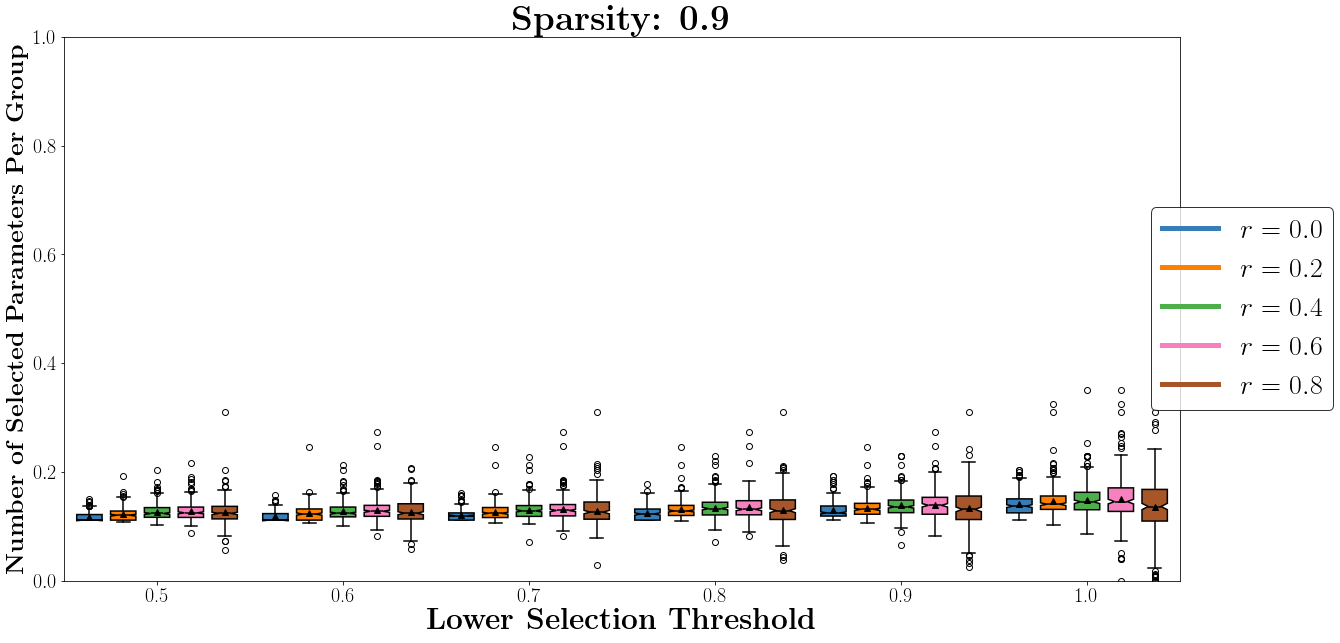

In [89]:
plot_mag_per_group(0.9, correlations=np.array([0.0, 0.2, 0.4, 0.6, 0.8]), scaled=True)

In [26]:
def calculate_n_per_group(sparsity, correlations):
    # extract files
    file = files[sparsity]
    # extract true and estimated parameters
    beta_hats = file['beta_hats']
    
    n_per_group = np.zeros((correlations.size, selection_thresholds.size, n_datasets * n_blocks))
    for corr_idx, correlation in enumerate(correlations):
        selected_betas = beta_hats[:, int(10 * correlation), :, :] != 0
        # split into groups: n_blocks-list of arrays of size n_datasets x n_selection_thresholds x block_size
        group_split = np.split(selected_betas, 5, axis=2)
        # sum up selectected betas
        summed_blocks = [np.sum(group, axis=2) for group in group_split]
        # put all the blocks together
        group_threshold = np.concatenate(summed_blocks, axis=0)
        # toss in array
        n_per_group[corr_idx, :, :] = group_threshold.T
    
    return n_per_group
    
def plot_n_per_group(sparsity, correlations, ax=None):
    n_per_group = calculate_n_per_group(sparsity, correlations)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    spread = np.linspace(-0.4, 0.4, correlations.size)
    base_positions = 1.1 * np.arange(selection_thresholds.size)
    for corr_idx, correlation in enumerate(correlations):
        ax.boxplot(
            [n_per_group[corr_idx, sel_idx, :] for sel_idx in range(selection_thresholds.size)],
            positions=base_positions + spread[corr_idx],
            widths=0.15,
            boxprops={'facecolor' : colors[corr_idx], 'linewidth' : 1.5},
            medianprops={'linewidth' : 1.5, 'color' : 'black', 'linestyle' : '--'},
            flierprops={'marker' : '.', 'markersize' : 12},
            whiskerprops={'linewidth' : 1.5},
            capprops={'linewidth' : 1.5},
            patch_artist=True,
            meanprops={'markerfacecolor' : 'black', 'markeredgecolor' : 'black'},
            showmeans=True,
            notch=True
        )
        # hack to get a label to show up
        ax.plot(0, 0, label=r'$r=%s$' %correlation, color=colors[corr_idx], linewidth=5)
    ax.set_xticks(base_positions)
    ax.set_xticklabels(selection_thresholds)
    ax.set_xlim(base_positions[0] + spread[0] - 0.15, base_positions[-1] + spread[-1] + 0.15)
    ax.set_ylim([0, 10])
    ax.set_xlabel(r'\textbf{Lower Selection Threshold}')
    ax.set_ylabel(r'\textbf{Number of Selected Parameters Per Group}', fontsize=25)
    lgd = ax.legend(
        loc='center right', 
        bbox_to_anchor=(1.15, 0.5),
        prop={'size' : 28}
    )
    lgd.get_frame().set_edgecolor('black')
    ax.set_title(r'\textbf{Sparsity: %0.1f}' %sparsity, fontsize=35)

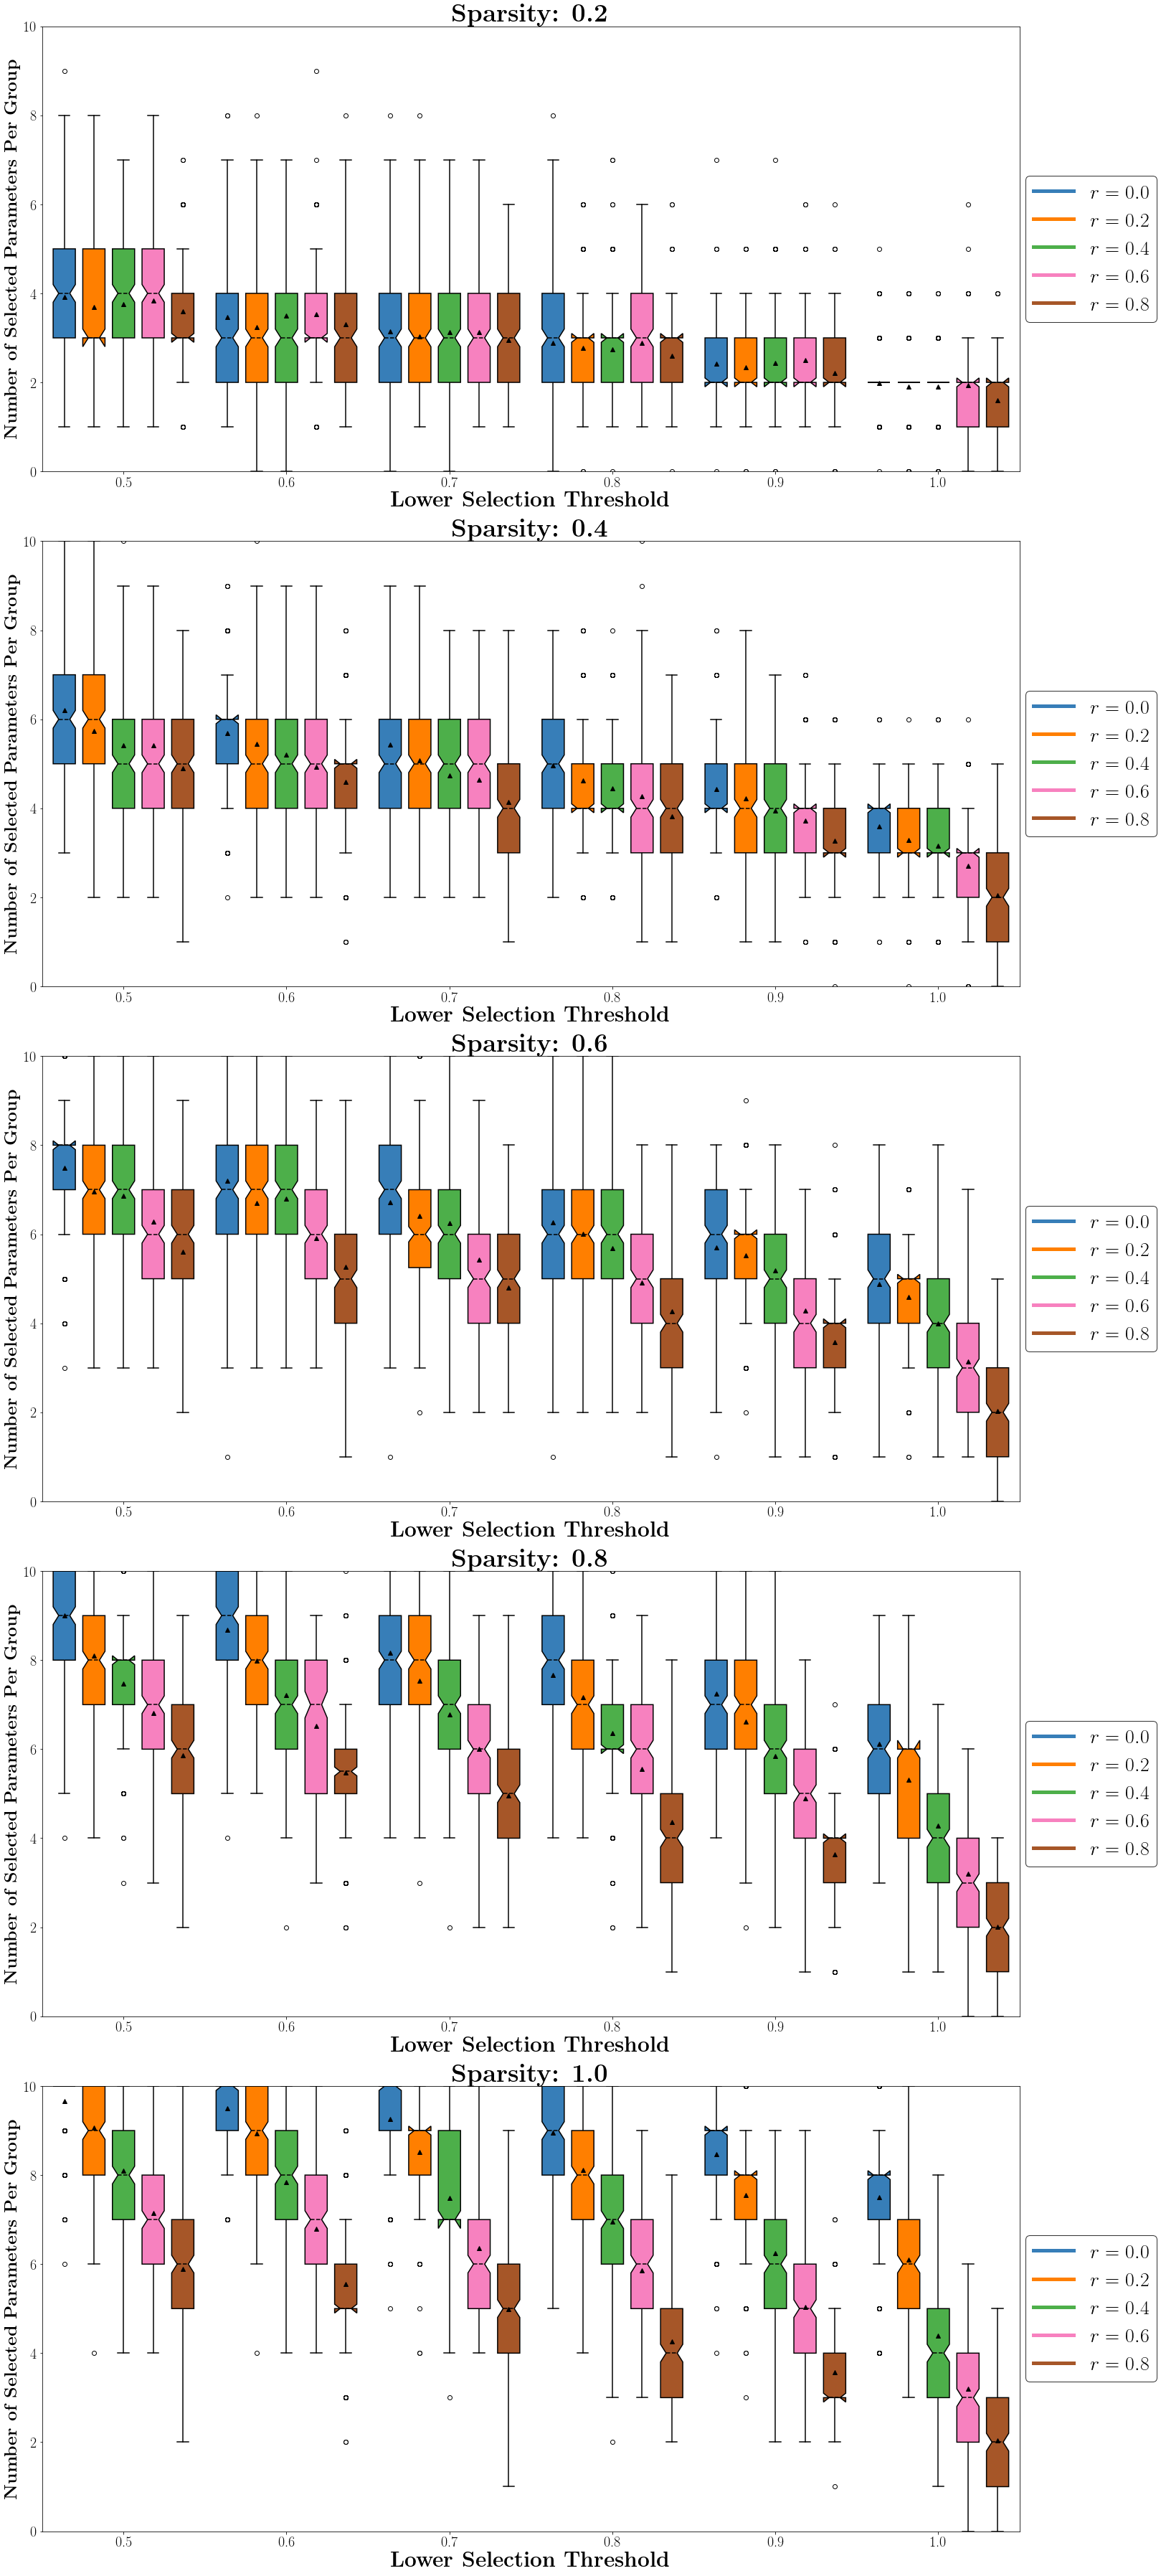

In [28]:
fig, axes = plt.subplots(5, 1, figsize=(20, 50))
plot_n_per_group(0.2, correlations=np.array([0, 0.2, 0.4, 0.6, 0.8]), ax=axes[0])
plot_n_per_group(0.4, correlations=np.array([0, 0.2, 0.4, 0.6, 0.8]), ax=axes[1])
plot_n_per_group(0.6, correlations=np.array([0, 0.2, 0.4, 0.6, 0.8]), ax=axes[2])
plot_n_per_group(0.8, correlations=np.array([0, 0.2, 0.4, 0.6, 0.8]), ax=axes[3])
plot_n_per_group(1.0, correlations=np.array([0, 0.2, 0.4, 0.6, 0.8]), ax=axes[4])
plt.tight_layout()
plt.savefig('exp2_n_per_group.pdf')

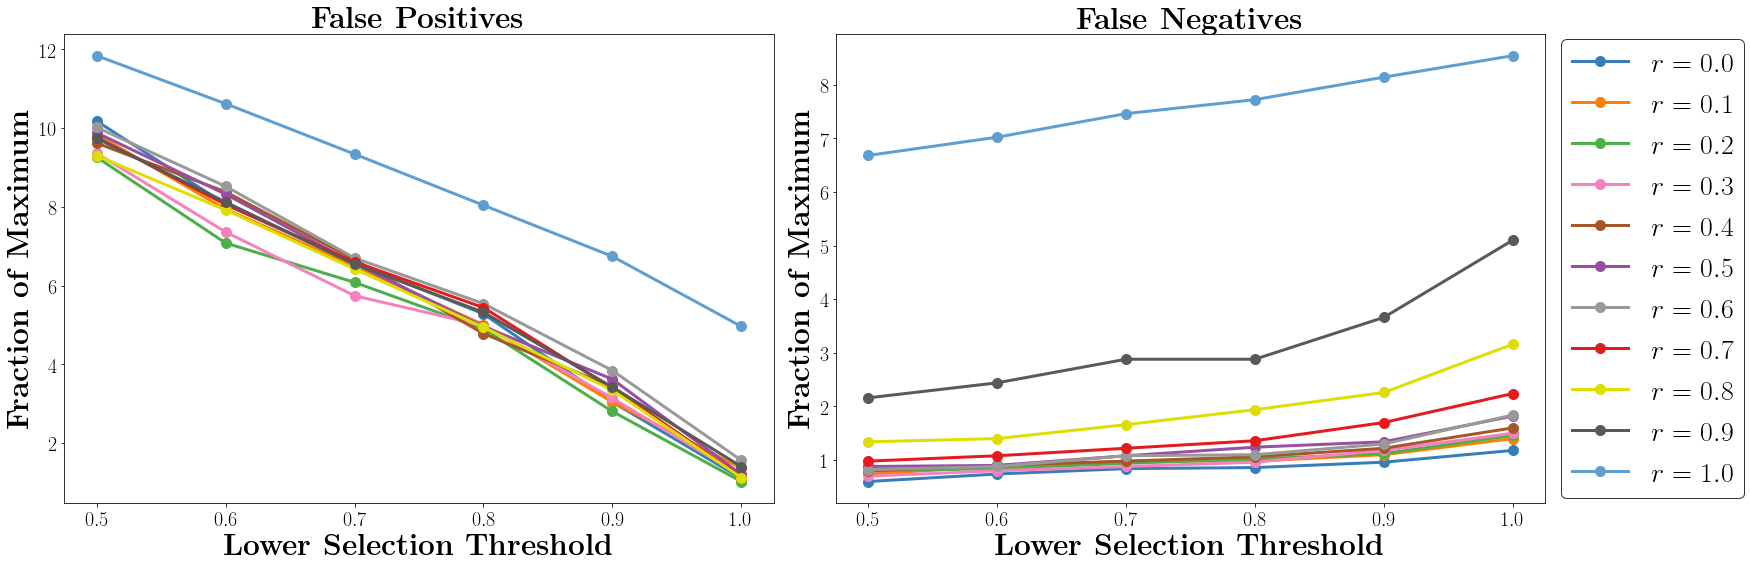

In [58]:
plot_fpfn(0.2)
#plt.savefig('exp2-01.pdf', bbox_inches='tight')

In [51]:
def set_overlap(true, hats):
    true_idx = np.argwhere(true).ravel()
    hats_idx = np.argwhere(hats).ravel()
    sym_set_diff = np.union1d(
        np.setdiff1d(true_idx, hats_idx),
        np.setdiff1d(hats_idx, true_idx)
    )
    set_overlap = sym_set_diff.size/(true_idx.size + hats_idx.size)
    return 1 - set_overlap

def selection_accuracy(sparsity):
    file = files[sparsity]
    # set up figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for corr_idx, correlation in enumerate(correlations):
        selection_accuracies = np.zeros((selection_thresholds.size, 50))
        for sel_thres_idx, selection_threshold in enumerate(selection_thresholds):
            for dataset in range(50):
                selection_accuracies[sel_thres_idx, dataset] = set_overlap(
                    file['beta'][dataset, :],
                    file['beta_hats'][dataset, corr_idx, sel_thres_idx :]
                )
        ax.plot(
            selection_thresholds, 
            np.mean(selection_accuracies, axis=1), 
            color=colors[corr_idx], 
            linewidth=3, 
            marker='o', 
            markersize=10,
            label=r'$r=%0.1f$' %correlation
        )
        
    ax.set_xlabel(r'\textbf{Lower Selection Threshold}')
    ax.set_ylabel(r'\textbf{Selection Accuracy}')
    ax.set_title(r'\textbf{Selection Accuracy}')

    lgd = ax.legend(
        loc='center right', 
        bbox_to_anchor=(1.4, 0.5),
        prop={'size' : 28}
    )
    lgd.get_frame().set_edgecolor('black')
    plt.tight_layout()

In [ ]:
selection_accuracy(0.9)
plt.savefig('exp2-09-selacc.pdf', bbox_inches='tight')